In [1]:
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
img_array = cv2.imread("train/0/Training_3908.jpg")

In [3]:
Datadirectory = "train/"

In [4]:
Classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [5]:
img_size = 224
training_data = []

def create_training_data():
    for category in Classes:
        path = os.path.join(Datadirectory, category)
        class_num = Classes.index(category)
        for img in os.listdir(path):
            try: 
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (img_size, img_size))
                training_data.append([new_array, class_num])
            except Exception as e:
                pass

create_training_data()

In [6]:
len(training_data)

28709

In [7]:
import random

random.shuffle(training_data)

In [8]:
X = [] #data
y = [] #label

for features, label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X, dtype=np.float32).reshape(-1, img_size, img_size, 3)

In [9]:
X = X/255

In [10]:
y = np.array(y)

In [11]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2

In [13]:
base_model = MobileNetV2(input_shape=(img_size, img_size, 3),
                        include_top=False,
                        weights='imagenet')  # You can specify 'imagenet' to load pre-trained weights

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

In [14]:
# base_input = model.layers[0].input
# base_output = model.layers[-2].output

In [15]:
# final_output = layers.Dense(128)(base_output)
# final_ouput = layers.Activation('relu')(final_output)
# final_output = layers.Dense(64)(final_ouput)
# final_ouput = layers.Activation('relu')(final_output)
# final_output = layers.Dense(7, activation='softmax')(final_ouput)

In [16]:
# Add your custom classification layers on top of the frozen base model
x = layers.GlobalAveragePooling2D()(base_model.output)
# x = layers.Dense(128, activation='relu')(x)
# x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(7, activation='softmax')(x)

In [28]:
new_model = keras.Model(inputs=base_model.input, outputs=output)

keras.utils.plot_model(new_model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [27]:
new_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics = ["accuracy"])

In [19]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [20]:
history = new_model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

Epoch 1/5
718/718 [==============================] - 599s 824ms/step - loss: 1.5441 - accuracy: 0.4095 - val_loss: 1.4111 - val_accuracy: 0.4774
Epoch 2/5
718/718 [==============================] - 566s 788ms/step - loss: 1.3776 - accuracy: 0.4767 - val_loss: 1.3812 - val_accuracy: 0.4788
Epoch 3/5
718/718 [==============================] - 545s 759ms/step - loss: 1.3300 - accuracy: 0.4979 - val_loss: 1.3896 - val_accuracy: 0.4793
Epoch 4/5
718/718 [==============================] - 540s 753ms/step - loss: 1.2966 - accuracy: 0.5112 - val_loss: 1.3828 - val_accuracy: 0.4814
Epoch 5/5
718/718 [==============================] - 545s 759ms/step - loss: 1.2688 - accuracy: 0.5178 - val_loss: 1.3907 - val_accuracy: 0.4807


In [21]:
new_model.save("temp.h5")

C:\Users\vince\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


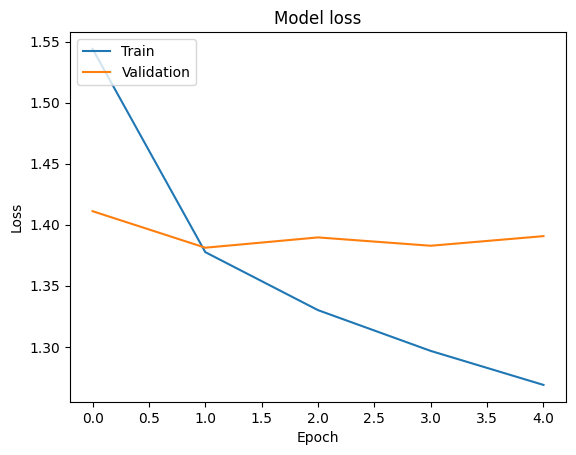

In [22]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

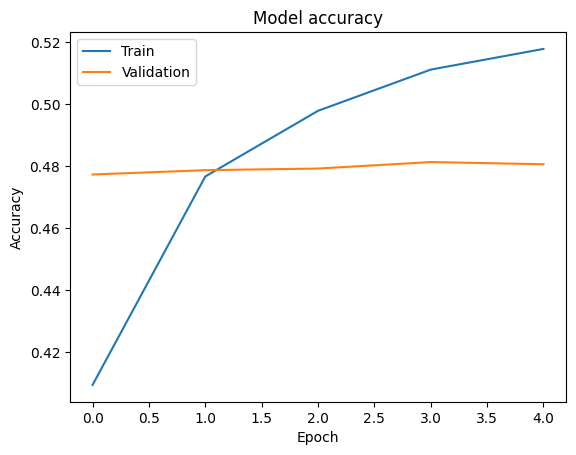

In [23]:

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [24]:
# Predict on the validation data
y_pred = new_model.predict(X_val)

# Get the class with the highest probability as the predicted class
y_pred_classes = np.argmax(y_pred, axis=1)

# Create a confusion matrix
confusion_mtx = confusion_matrix(y_val, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=Classes, yticklabels=Classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

MemoryError: Unable to allocate 3.22 GiB for an array with shape (5742, 224, 224, 3) and data type float32